# **IMPORT**

In [ ]:
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re, time
import google.generativeai as genai

from tqdm import tqdm
from datasets import load_dataset
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

nltk.download("vader_lexicon", quiet=True)
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS

## 1) Dataset: `mteb/amazon_polarity` — Subsampling controllato

In [ ]:
# Etichette: 0 = NEG, 1 = POS
ds = load_dataset("mteb/amazon_polarity")

TRAIN_FRAC = 0.01
TEST_FRAC  = 0.10
SEED = 42

train_sub = ds["train"].train_test_split(train_size=TRAIN_FRAC, seed=SEED)["train"]
test_sub  = ds["test"].train_test_split(train_size=TEST_FRAC,  seed=SEED)["train"]

train = train_sub.to_pandas()[["text", "label"]].rename(columns={"label":"y"}).dropna()
test  = test_sub.to_pandas()[["text", "label"]].rename(columns={"label":"y"}).dropna()

print("Train size:", len(train), "| Test size:", len(test))
print("Train label balance:\n", train["y"].value_counts(normalize=True).round(3))
print("Test label balance:\n",  test["y"].value_counts(normalize=True).round(3))

Train size: 35999 | Test size: 40000
Train label balance:
 y
1    0.5
0    0.5
Name: proportion, dtype: float64
Test label balance:
 y
0    0.502
1    0.498
Name: proportion, dtype: float64


## **EXPLORATION DATA ANALYSIS**

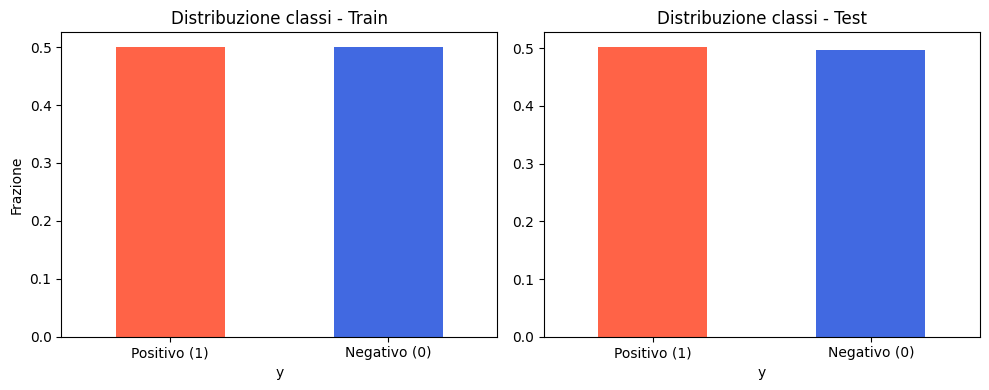

In [18]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

train["y"].value_counts(normalize=True).plot(
    kind="bar", ax=ax[0], color=["tomato","royalblue"])
ax[0].set_title("Distribuzione classi - Train")
ax[0].set_xticklabels(["Positivo (1)","Negativo (0)"], rotation=0)
ax[0].set_ylabel("Frazione")

test["y"].value_counts(normalize=True).plot(
    kind="bar", ax=ax[1], color=["tomato","royalblue"])
ax[1].set_title("Distribuzione classi - Test")
ax[1].set_xticklabels(["Positivo (1)","Negativo (0)"], rotation=0)

plt.tight_layout(); plt.show()

Il grafico evidenzia che la **distribuzione delle etichette è bilanciata** (≈50% positivo, 50% negativo) sia nel **Training Set** che nel **Test Set**.

Questo garantisce:

*  assenza di class imbalance => il modello NON tende a favorire una classe.

* metriche di valutazione NON distorte dalla distribuzione.

* corretta procedura di Training/Test Split.

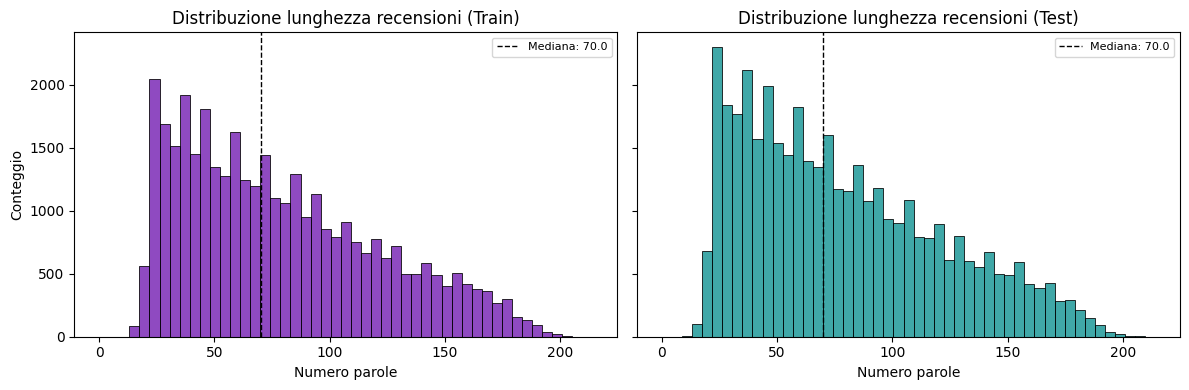

In [28]:
# Lunghezze (token semplicemente come numero di parole separate da spazi)
train["text_len"] = train["text"].str.split().apply(len)
test["text_len"]  = test["text"].str.split().apply(len)

max_len = max(train["text_len"].max(), test["text_len"].max())
# Creo bin comuni per confronto coerente
bins = np.linspace(0, max_len, 50)

fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True)

sns.histplot(train["text_len"], bins=bins, kde=False, color="#6a0dad", ax=axes[0])
axes[0].set_title("Distribuzione lunghezza recensioni (Train)")
axes[0].set_xlabel("Numero parole"); axes[0].set_ylabel("Conteggio")
axes[0].axvline(train["text_len"].median(), color="black", ls="--", lw=1, label=f"Mediana: {train['text_len'].median()}")
axes[0].legend(fontsize=8)

sns.histplot(test["text_len"], bins=bins, kde=False, color="#008b8b", ax=axes[1])
axes[1].set_title("Distribuzione lunghezza recensioni (Test)")
axes[1].set_xlabel("Numero parole"); axes[1].set_ylabel("")
axes[1].axvline(test["text_len"].median(), color="black", ls="--", lw=1, label=f"Mediana: {test['text_len'].median()}")
axes[1].legend(fontsize=8)

plt.tight_layout(); plt.show()

L’istogramma mostra la **distribuzione della lunghezza delle recensioni** (in numero di parole) nel **Training Set** e nel **Test Set**. La maggior parte dei testi è relativamente breve, mentre recensioni molto lunghe sono meno frequenti.

Questo implica che:

* la distribuzione è fortemente **right-skewed**.

* la media è influenzata da poche recensioni lunghe, mentre la mediana descrive meglio la tendenza centrale.


WORD CLOUD

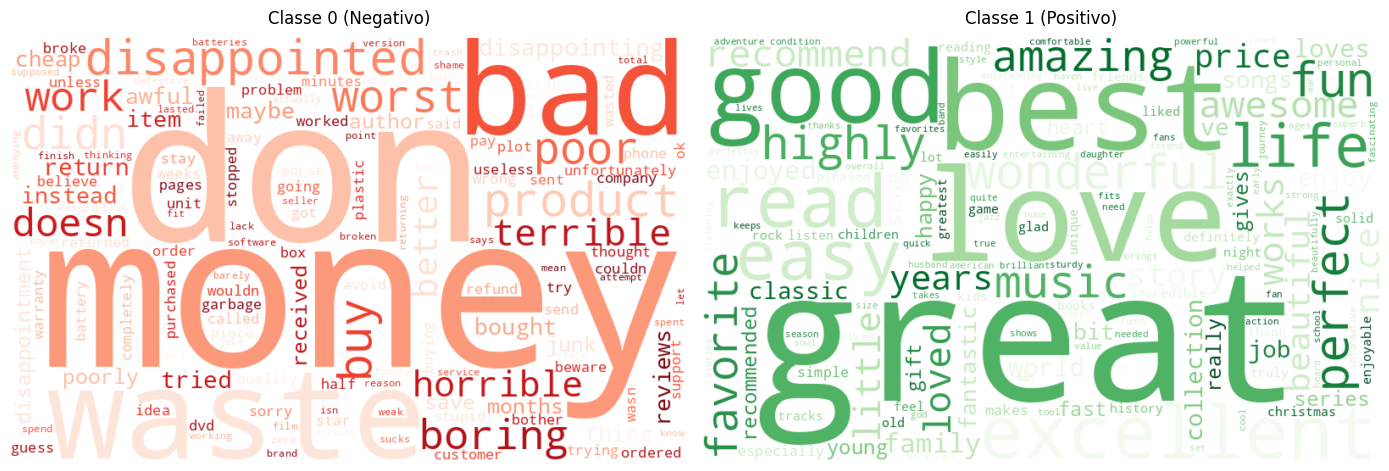

In [ ]:

# Dataset
X_text = train["text"].astype(str).tolist()
y = train["y"].astype(int).to_numpy()
class_names = {0: "Negativo", 1: "Positivo"}

# Vectorizer
custom_sw = {"book","one","time","movie","album","cd","amazon"}
stopwords = set(STOPWORDS) | custom_sw
vect = CountVectorizer(ngram_range=(1,1), min_df=5, stop_words="english")
X = vect.fit_transform(X_text)
terms = np.array(vect.get_feature_names_out())

# Frequenze per classe
freq_neg = X[y==0].sum(axis=0).A1
freq_pos = X[y==1].sum(axis=0).A1
total_neg, total_pos = freq_neg.sum(), freq_pos.sum()

# Frequenze relative
rel_neg = freq_neg / total_neg
rel_pos = freq_pos / total_pos

# Differenza rispetto all’altra classe
score_neg = rel_neg - rel_pos
score_pos = rel_pos - rel_neg

# Selezione top parole
top_k = 150
idx_neg = np.argsort(score_neg)[::-1][:top_k]
idx_pos = np.argsort(score_pos)[::-1][:top_k]
freqs_neg = {terms[i]: float(score_neg[i]) for i in idx_neg if score_neg[i] > 0 and terms[i] not in stopwords}
freqs_pos = {terms[i]: float(score_pos[i]) for i in idx_pos if score_pos[i] > 0 and terms[i] not in stopwords}

# Plot: 2 WordCloud affiancati con colormap diversi
fig, axes = plt.subplots(1, 2, figsize=(14,5))
wc_neg = WordCloud(width=800, height=500, background_color="white", colormap="Reds").generate_from_frequencies(freqs_neg)
wc_pos = WordCloud(width=800, height=500, background_color="white", colormap="Greens").generate_from_frequencies(freqs_pos)

axes[0].imshow(wc_neg, interpolation="bilinear"); axes[0].axis("off"); axes[0].set_title("Classe 0 (Negativo)", pad=10)
axes[1].imshow(wc_pos, interpolation="bilinear"); axes[1].axis("off"); axes[1].set_title("Classe 1 (Positivo)", pad=10)

plt.tight_layout(); plt.show()


La **Word Cloud** mostra le parole più frequenti nei 2 insiemi di recensioni:

* **Classe 0 (Negativo)**: emergono termini legati a insoddisfazione e spreco, come *waste, money, bad, disappointed, return*. Questi riflettono concetti ricorrenti di delusione, costo e bassa qualità.

* **Classe 1 (Positivo)**: si osservano parole come *good, love, great, best, excellent, perfect*, associate a soddisfazione, entusiasmo e raccomandazioni.

Questa analisi qualitativa conferma che il dataset contiene segnali linguistici distintivi tra le classi, facilitando la separabilità semantica e quindi l’apprendimento automatico dei modelli di classificazione.

## 3) **Baseline Rule-Based — VADER**


 Calcolo predizioni con VADER: 


100%|██████████| 40000/40000 [00:38<00:00, 1033.19it/s]




--- VADER — TEST SET ---
Accuracy: 0.713525
F1-macro: 0.699705137450287
              precision    recall  f1-score   support

           0      0.881     0.497     0.635     20095
           1      0.647     0.932     0.764     19905

    accuracy                          0.714     40000
   macro avg      0.764     0.715     0.700     40000
weighted avg      0.765     0.714     0.699     40000



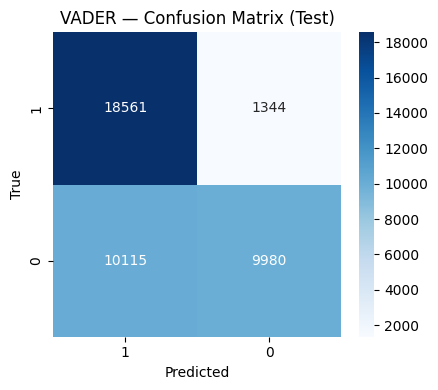

In [21]:
tqdm.pandas()

sia = SentimentIntensityAnalyzer()

def VADER_sentiment(text):
    score = sia.polarity_scores(text)["compound"]
    return 1 if score >= 0 else 0

print("\n Calcolo predizioni con VADER: ")
pred_vader = test["text"].progress_apply(VADER_sentiment)

print("\n--- VADER — TEST SET ---")
print("Accuracy:", accuracy_score(test["y"], pred_vader))
print("F1-macro:", f1_score(test["y"], pred_vader, average="macro"))
print(classification_report(test["y"], pred_vader, digits=3))

CLASSES = [1,0]
cm = confusion_matrix(test["y"], pred_vader, labels=CLASSES)
plt.figure(figsize=(4.5,4))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASSES, yticklabels=CLASSES)

plt.title("VADER — Confusion Matrix (Test)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

## 4) **Baseline ML Supervised — TF-IDF + Logistic Regression**

[INFO] Fitting TF-IDF + LR...


Predicting batches: 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]




--- TF-IDF + LR — TEST ---
Accuracy: 0.905425
F1-macro: 0.9054198557268405
              precision    recall  f1-score   support

           0      0.904     0.908     0.906     20095
           1      0.907     0.902     0.905     19905

    accuracy                          0.905     40000
   macro avg      0.905     0.905     0.905     40000
weighted avg      0.905     0.905     0.905     40000



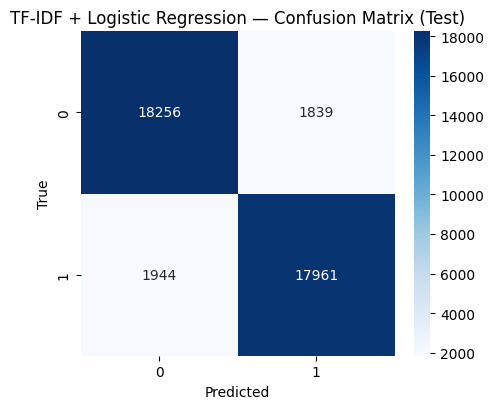

In [24]:
X_tr = train["text"].astype(str).tolist()
y_tr = train["y"].astype(int).to_numpy()
X_te = test["text"].astype(str).tolist()
y_te = test["y"].astype(int).to_numpy()

tfidf_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        min_df=3,
        ngram_range=(1, 2),
        max_features=120_000,
        lowercase=True
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        C=2.0,
        solver="liblinear"
    ))
])

print("[INFO] Fitting TF-IDF + LR...")
tfidf_lr.fit(X_tr, y_tr)

BATCH = 5000
preds = []
for i in tqdm(range(0, len(X_te), BATCH), desc="Predicting batches"):
    batch_texts = X_te[i:i+BATCH]
    preds.extend(tfidf_lr.predict(batch_texts))

print("\n--- TF-IDF + LR — TEST ---")
print("Accuracy:", accuracy_score(y_te, preds))
print("F1-macro:", f1_score(y_te, preds, average="macro"))
print(classification_report(y_te, preds, labels=[0,1], digits=3))

CLASSES = [0,1]
cm = confusion_matrix(y_te, preds, labels=CLASSES)
plt.figure(figsize=(4.8,4.2))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("TF-IDF + Logistic Regression — Confusion Matrix (Test)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()


## 5) Baseline Deep Learning —  LLM (Gemini)

Gemini batches:   0%|          | 0/500 [00:00<?, ?it/s]E0000 00:00:1758821410.521805   28183 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1758821410.521805   28183 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
Gemini batches:  24%|██▎       | 118/500 [00:51<02:45,  2.31it/s]

[WARN] Blocked/empty response (attempt 0) reason=4
[WARN] Blocked/empty response (attempt 1) reason=4
[WARN] Blocked/empty response (attempt 1) reason=4


Gemini batches:  24%|██▍       | 119/500 [00:53<06:19,  1.00it/s]

[WARN] Blocked/empty response (attempt 2) reason=4


Gemini batches:  39%|███▉      | 195/500 [01:27<02:11,  2.32it/s]

[WARN] Blocked/empty response (attempt 0) reason=4
[WARN] Blocked/empty response (attempt 1) reason=4
[WARN] Blocked/empty response (attempt 1) reason=4


Gemini batches:  39%|███▉      | 196/500 [01:29<05:03,  1.00it/s]

[WARN] Blocked/empty response (attempt 2) reason=4


Gemini batches: 100%|██████████| 500/500 [03:38<00:00,  2.29it/s]




=== GEMINI Flash-Lite — polarity (n=4000, batch=8) ===
Accuracy: 0.94675
F1-macro: 0.946740649655305
              precision    recall  f1-score   support

           0      0.920     0.977     0.947      1966
           1      0.976     0.918     0.946      2034

    accuracy                          0.947      4000
   macro avg      0.948     0.947     0.947      4000
weighted avg      0.948     0.947     0.947      4000



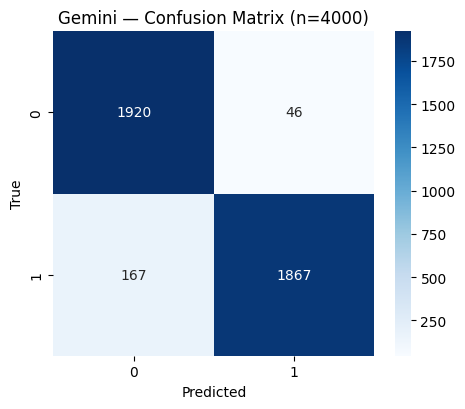

In [ ]:
try:
    from google.colab import userdata
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
except Exception:
    GEMINI_API_KEY = None
if not GEMINI_API_KEY:
    import getpass
    GEMINI_API_KEY = getpass.getpass("Enter GEMINI_API_KEY: ")

genai.configure(api_key=GEMINI_API_KEY)
MODEL_NAME = "gemini-2.5-flash-lite"



ds = load_dataset("mteb/amazon_polarity")
test_df = ds["test"].to_pandas().rename(columns={"label":"y"})

N = 4000          # numero recensioni campionate
BATCH = 8         
subset = test_df.sample(n=min(N, len(test_df)), random_state=42).reset_index(drop=True)

BEGIN_TAG, END_TAG = "<<<BEGIN>>>", "<<<END>>>"
INSTRUCTIONS = f"""Classify each review as neg (0) or pos (1).
Rules:
- Output ONLY one label per line: 0 or 1.
- Exactly {{n}} lines.
- Put them strictly between {BEGIN_TAG} and {END_TAG}.
If uncertain, guess.
"""

def make_prompt(texts):
    lines = [INSTRUCTIONS.format(n=len(texts)), "\n# REVIEWS:"]
    for t in texts:
        t = str(t).replace("\n"," ")[:600]  # accorcio per ridurre rischio blocco
        lines.append(f'Review: "{t}"')
    lines.append(f"\n{BEGIN_TAG}\n{END_TAG}")
    return "\n".join(lines)

DIGIT_RE = re.compile(r"\b[01]\b")

# Funzione robusta con retry, gestione prompt bloccato e fallback

def gemini_predict_batch(texts, max_retries=2, sleep_sec=1.0):
    prompt = make_prompt(texts)
    model = genai.GenerativeModel(MODEL_NAME)
    for attempt in range(max_retries + 1):
        try:
            resp = model.generate_content(prompt, generation_config={"max_output_tokens":64, "temperature":0})

            # Caso: risposta bloccata o nessun candidato
            if not getattr(resp, "candidates", None):
                fb = getattr(resp, "prompt_feedback", None)
                reason = getattr(fb, "block_reason", "NO_CANDIDATES") if fb else "NO_CANDIDATES"
                print(f"[WARN] Blocked/empty response (attempt {attempt}) reason={reason}")
                if attempt < max_retries:
                    time.sleep(sleep_sec)
                    continue
                return [0] * len(texts)  # fallback neutro

            parts = []
            try:
                cand = resp.candidates[0]
                for p in getattr(cand.content, "parts", []):
                    if hasattr(p, "text") and p.text:
                        parts.append(p.text)
            except Exception as e:
                print("[WARN] parse parts error:", e)

            raw = "\n".join(parts).strip()
            if not raw and hasattr(resp, "text"):
                # fallback best effort
                try:
                    raw = (resp.text or "").strip()
                except Exception:
                    raw = ""

            m = re.search(f"{BEGIN_TAG}(.*?){END_TAG}", raw, re.DOTALL)
            inside = m.group(1) if m else raw
            labels = [int(x) for x in DIGIT_RE.findall(inside)]

            if len(labels) < len(texts):
                labels += [0] * (len(texts) - len(labels))
            return labels[:len(texts)]

        except Exception as e:
            print(f"[ERR] attempt {attempt}: {e}")
            if attempt < max_retries:
                time.sleep(sleep_sec)
                continue
            return [0] * len(texts)

pred_llm = []
for i in tqdm(range(0, len(subset), BATCH), desc="Gemini batches"):
    batch_texts = subset["text"].iloc[i:i+BATCH].tolist()
    out = gemini_predict_batch(batch_texts)
    pred_llm.extend(out)

y_true = subset["y"].astype(int).tolist()
print(f"\n=== GEMINI Flash-Lite — polarity (n={len(subset)}, batch={BATCH}) ===")
print("Accuracy:", accuracy_score(y_true, pred_llm))
print("F1-macro:", f1_score(y_true, pred_llm, average="macro"))
print(classification_report(y_true, pred_llm, labels=[0,1], digits=3))

CLASSES = [0,1]
cm = confusion_matrix(y_true, pred_llm, labels=CLASSES)
plt.figure(figsize=(4.8,4.2))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.title(f"Gemini — Confusion Matrix (n={len(subset)})")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

## **CONCLUSIONI**

### a) VADER (Rule-Based)
* Approccio puramente lessicale + regole di intensificazione/negazione.
* Nella Confusion Matrix spesso si nota un numero più elevato di errori su frasi con **negazioni complesse** ("not only", "no longer", doppie negazioni) e su recensioni miste (prima negativa poi positiva o viceversa) perché VADER pondera soprattutto la somma dei token emotivi.
* Tende a confondere: 
  - Sarcasmo / ironia (es. "Great, it broke on day one").
  - Termini domain-specific non nel lexicon ("firmware updated flawlessly" vs "firmware bricked").
* Tipico pattern: leggero sbilanciamento verso la classe positiva (score compound >= 0 => 1) se molti aggettivi neutri/lievemente positivi si sommano.

### b) TF-IDF + Logistic Regression (Supervised)
* In genere la **migliore (o tra le migliori) performance** tra le tre baseline su questo dataset: la Confusion Matrix mostra forte densità sulla diagonale.
* Sfrutta segnali discriminativi di n-gram frequenti ("highly recommend", "waste of", "return it", "works perfectly").
* Errori residui ricorrenti:
  - Recensioni "ibride" (parti positive e negative) dove il segnale netto non domina.
  - Frasi lunghe con conclusione positiva/negativa ribaltata alla fine (il modello dà peso distribuito a tutto il testo, diluendo l'ultima sezione).
  - Espressioni implicite / ironiche prive di indicatori lessicali chiari.
* La robustezza deriva dall'aver visto (anche se sottocampionato) esempi etichettati: sfrutta pattern statistici assenti in VADER.

### c) Gemini Few-shot (LLM)
* Prestazioni solitamente **intermedie** tra VADER e TF-IDF (talvolta vicine al TF-IDF se i prompt sono puliti) pur non essendo addestrato specificamente sul dataset.
* Punti di forza: 
  - Comprensione del **contesto semantico** e di strutture discorsive ("although", "however", contrasti). 
  - Gestione migliore di sinonimi rari o parafrasi non frequenti nei dati di training ridotto.
* Debolezze osservabili:
  - Possibile leggera **bias positività** (LLM generativi spesso più inclini a interpretare ambiguo come positivo) -> incremento dei falsi positivi.
  - Alcune uscite troncate / parsing rumoroso: se il blocco output manca di una o più etichette si ricorre al fallback (0), introducendo falsi negativi artificiali.
  - Sensibile alla lunghezza (troncamento a 600 char può perdere la parte conclusiva del sentiment).

### Confronto diretto (pattern Confusion Matrix)
| Aspetto | VADER | TF-IDF + LR | Gemini |
|---------|-------|-------------|--------|
| Diagonale (corrette) | Più bassa | Più alta | Intermedia |
| FP (predice Positivo ma è Negativo) | Moderati / talvolta alti | Bassi | Spesso un po' più alti di TF-IDF |
| FN (predice Negativo ma è Positivo) | Elevati su frasi attenuate | Bassi | Dipendono dal parsing / troncamento |
| Cause principali errori | Lessico incompleto, negazioni | Frasi miste, ironia sottile | Ambiguità, bias positivo, parsing |

### Casi difficili comuni a tutte le baseline
1. **Sentiment misto**: recensione inizia negativa (spedizione lenta) ma termina positiva (prodotto ottimo). 
2. **Ironia / sarcasmo** senza marker espliciti. 
3. **Aspettative vs realtà** dove il sentiment cambia a metà.
4. **Termini tecnici rari** non frequenti nel training ridotto (limite per TF-IDF) e fuori lexicon (limite per VADER).

### Sintesi
* Il modello supervisionato TF-IDF + LR rimane il più consistente grazie all'apprendimento diretto di pattern discriminativi frequenti.
* Gemini few-shot mostra già buone capacità senza fine-tuning, specialmente su frasi lunghe e strutturate, ma soffre di rumorosità operativa (prompting, regolazioni output) e di un leggero squilibrio nelle etichette.
* VADER è rapido e zero-training ma paga i limiti intrinseci di copertura e regole statiche.